In [1]:
import pandas as pd
import os
import pickle
os.chdir('..')
import plotly.express as px
from utils import *

# ml imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import DMatrix
import xgboost as xgb

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# logging
from matplotlib import pyplot as plt
import wandb
from wandb.xgboost import WandbCallback
from bayes_opt import BayesianOptimization

wandb.login()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [15]:
#df_first = pd.read_csv(r'data\raw_data\UTC_id1_data.csv', index_col=0, parse_dates=True, sep=';').iloc[:,:1]

df_first = pd.read_csv(r'data\cleaned_data\5_household\power\15min_36_train.csv', index_col=0, parse_dates=True)
df_first = df_first.resample('60min').mean()
df_first.columns = ['power']

In [16]:
# Data cleaning
#-----------------------#
df = remove_duplicate_index(df_first)

df = remove_days(df, 0.2)

df = remove_non_positive_values(df)

df_clean = df.copy()

Removed 73 days with less than 20.0% of average total energy consumption of all days


In [17]:
px.line(df_clean, y='power')

array([[<Axes: title={'center': 'power'}>]], dtype=object)

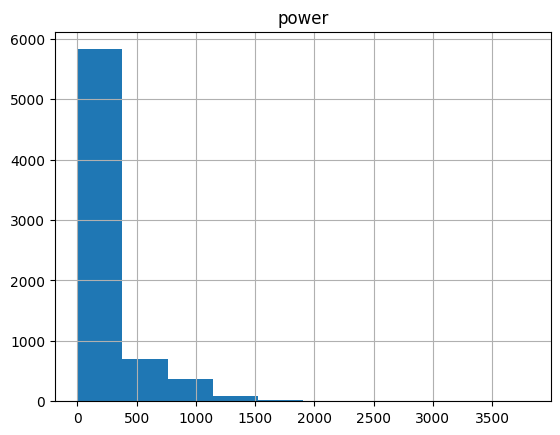

In [18]:
df_clean.hist()

In [19]:
def timeseries_peak_feature_extractor(df):
    'Extracts peak count, maximum peak height, and time of two largest peaks for each day in a pandas dataframe time series'
    
    timesteplen = infer_frequency(df_clean).seconds // 60
    timesteps_per_day = 24*60//timesteplen
    
    # Find peaks
    peak_idx = find_peaks_cwt(df.values.flatten(), widths=3, max_distances=[timesteps_per_day//2], window_size=timesteps_per_day)
    
    # Convert peak indices to datetime indices
    peak_times = [df.index[i] for i in peak_idx]
    
    # Group peaks by day
    peak_days = pd.Series(peak_times).dt.date
    
    # Count peaks for each day
    daily_peak_count = peak_days.value_counts().sort_index()
    
    # Find maximum and second maximum peak height and time for each day
    daily_peak_height = []
    daily_peak_time = []
    daily_second_peak_height = []
    daily_second_peak_time = []
    
    for day in daily_peak_count.index:
        day_peaks = [peak_idx[i] for i in range(len(peak_idx)) if peak_times[i].date() == day]
        day_peak_vals = [df.values[i] for i in day_peaks]
        
        max_idx = np.argmax(day_peak_vals)
        daily_peak_height.append(day_peak_vals[max_idx][0])
        daily_peak_time.append((day_peaks[max_idx] % timesteps_per_day))
        
        if len(day_peak_vals) > 1:
            day_peak_vals[max_idx] = -np.inf
            second_max_idx = np.argmax(day_peak_vals)
            daily_second_peak_height.append(day_peak_vals[second_max_idx][0])
            daily_second_peak_time.append((day_peaks[second_max_idx] % timesteps_per_day))
        else:
            daily_second_peak_height.append(0)
            daily_second_peak_time.append(0)
    
    # Combine results into output DataFrame
    output_df = pd.DataFrame({
                              'height_highest_peak': daily_peak_height,
                              'time_highest_peak': daily_peak_time,
                              'height_second_highest_peak': daily_second_peak_height,
                              'time_second_highest_peak': daily_second_peak_time},
                             index=daily_peak_count.index)
    
    return output_df

Text(0.5, 0, 'Power consumption [W]')

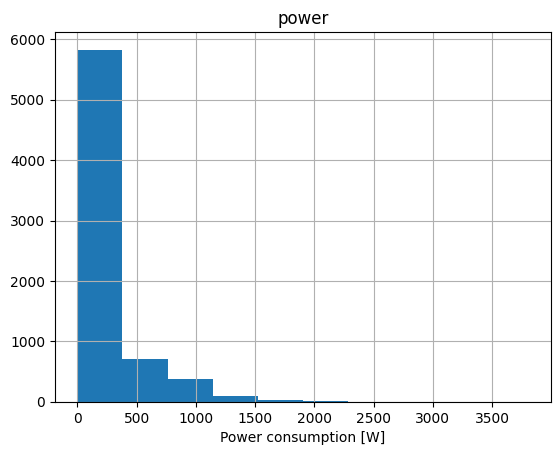

In [23]:
df_clean.hist()
plt.xlabel('Power consumption [W]')

In [21]:
config_features = {
    'holidays': True,
    'holidays_country': 'AT',
    'peaks': True,
    'lagged_days': [1,7,14],
    'boxcox': True,
    'lam': None,
    'cumsum': False,
    'datetime': True,
    }



array([[<Axes: title={'center': 'power'}>]], dtype=object)

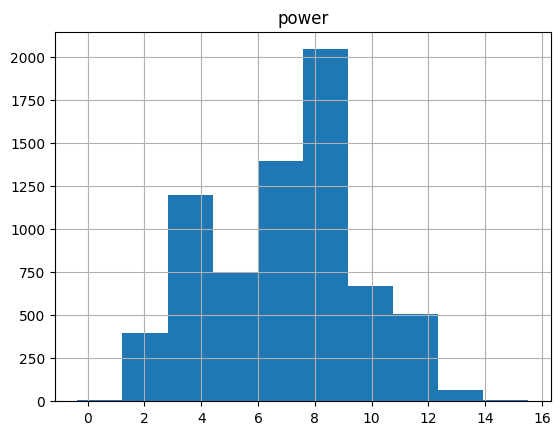

In [22]:
wandb.init(
    project="XGBoost",
    )

wandb.config.update(config_features)

config = wandb.config

#-----------------------#

df = df_clean.copy()
# Feature Engineering
#-----------------------#
if config.boxcox:
    df, config.lam = boxcox_transform(df)



Text(0.5, 0, 'Power consumption [W]')

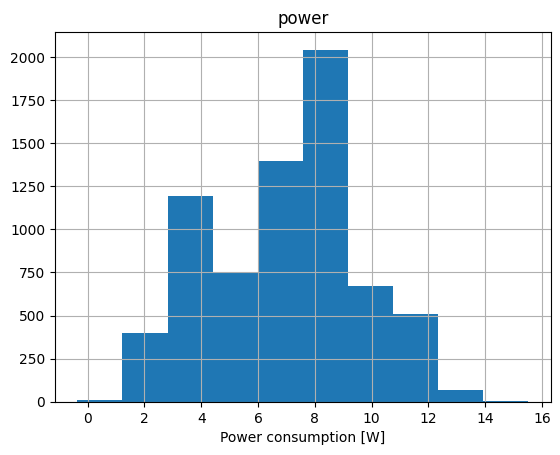

In [24]:

df.hist()
plt.xlabel('Power consumption [W]')

In [ ]:

# scaling the data

scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


# long to wide format, because we are doing daily predictions
df_pivot = timeseries_dataframe_pivot(df).dropna()
n_timesteps_per_output = df_pivot.shape[1]

    # peaks
if config.peaks:
    df_peak_feature = timeseries_peak_feature_extractor(df)
    for i in config.lagged_days:
        df_peak_feature_shifted = df_peak_feature.shift(i)
        df_peak_feature_shifted.columns = [f"{col}_lag_{i}" for col in df_peak_feature_shifted.columns]
        df_pivot = pd.merge(df_pivot, df_peak_feature_shifted, left_index=True, right_index=True, how='left')
        df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot = df_pivot.dropna()

# past information
if config.cumsum:
    df_pivot["load_of_last_day"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(1)
    df_pivot["load_of_same_day_last_week"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(7)


# holidays
if config.holidays:
    years = get_year_list(df_pivot)
    df_holidays_dummies = get_holidays(years, config.holidays_country)
    df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
    df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

# datetime features
if config.datetime:
    df_pivot = create_datetime_features(df_pivot)

df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

#-----------------------#

# Splits 

#-----------------------#
test_size = 0.1
train, test = train_test_split(df_final, test_size=test_size, shuffle=True, random_state=42)
test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_output]).index

#features and target
X_train = train.iloc[:,n_timesteps_per_output:]
y_train = train.iloc[:,:n_timesteps_per_output]

X_test = test.iloc[:,n_timesteps_per_output:]
y_test = test.iloc[:,:n_timesteps_per_output]


scaler_features = MinMaxScaler()
X_train[X_train.columns] = scaler_features.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler_features.transform(X_test[X_test.columns])

#-----------------------#


dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)


,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
date,,,,,,,,,,,,,,,,,,,,,
2021-05-19,0.641851,0.622215,0.645975,0.642044,0.655831,0.728712,0.660371,0.650186,0.689033,0.683383,...,0.882725,0.754901,0.685852,0.685327,0.699905,0.654311,0.649979,0.648542,0.642476,0.636239
2022-04-15,0.652662,0.650914,0.653715,0.644695,0.656011,0.888035,0.753109,0.820408,0.746756,0.748979,...,0.813211,0.771746,0.778790,0.733624,0.699341,0.697890,0.680501,0.699277,0.699916,0.685600
2021-07-20,0.671677,0.645242,0.671630,0.665667,0.661224,0.706189,0.679315,0.886829,0.767904,0.701551,...,0.672168,0.671779,0.885552,0.825017,0.724010,0.706338,0.682795,0.679913,0.682463,0.680852
2021-03-08,0.676449,0.637502,0.664421,0.662219,0.662258,0.694686,0.669296,0.669163,0.675694,0.822771,...,0.680944,0.677262,0.697890,0.747179,0.838071,0.821258,0.669759,0.665439,0.662624,0.668541
2023-11-02,0.647449,0.655486,0.625544,0.652018,0.667393,0.614034,0.671713,0.699881,0.679349,0.700015,...,0.695844,0.692592,0.730706,0.732216,0.735370,0.729745,0.717510,0.659297,0.897093,0.775600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-11,0.635535,0.615136,0.650555,0.645563,0.638034,0.632429,0.861725,0.684917,0.947221,0.944027,...,0.693551,0.686504,0.722041,0.706470,0.708224,0.712867,0.703986,0.642118,0.640065,0.625617
2021-08-26,0.649988,0.617830,0.636188,0.634016,0.629853,0.696339,0.649712,0.793367,0.858556,0.799421,...,0.863598,0.732891,0.656437,0.701127,0.677580,0.640288,0.633486,0.637930,0.637397,0.633604
2022-04-08,0.658849,0.645296,0.657014,0.628989,0.654460,0.869219,0.722011,0.684526,0.660221,0.703356,...,0.651273,0.665743,0.711731,0.746857,0.835247,0.813615,0.705442,0.663244,0.655453,0.653510


In [182]:
params = {'colsample_bytree': 0.9, 
            'learning_rate': 0.2, 
            'max_depth': 13, 
            'min_child_weight': 1,
            'reg_lambda': 0.4,
            'subsample': 0.6,
            'gamma': 0,
            'objective': 'reg:pseudohubererror',
            'huber_slope': 0.15,
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'num_parallel_tree': 1,
             }
        
wandb.config.update(params)
model = xgb.train(dtrain= dtrain, params=params, 
                  early_stopping_rounds=10,
                  evals=[(dtest, "Test"), (dtrain, "Train")], 
                  custom_metric=peak_error, maximize=False, verbose_eval=10, callbacks=[WandbCallback()])
predictions = model.predict(dtest)



[0]	Test-mphe:0.00715	Test-peak_error:0.13524	Train-mphe:0.00705	Train-peak_error:0.14123
[9]	Test-mphe:0.00243	Test-peak_error:0.06300	Train-mphe:0.00051	Train-peak_error:0.04034


In [183]:
predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, config.lam)
gt = df_first.loc[test_idx].values.flatten()

df_compare = pd.DataFrame({
                        'ground truth':gt,
                        'prediction': predictions_reshaped
                        }
                        )


# -----------------------#
fig2 = px.line(df_compare)
fig2.update_layout(title='XGBoost Predictions vs Ground Truth: Michael Stadler Household Data')
fig2.show()
wandb.log({"Line-Plot":fig2})



0.06488068678895687


In [19]:
def xgb_obj(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, n_estimators , reg_lambda, reg_alpha, huber_slope, gamma):
    
    wandb.init(project='XGBoost')
    wandb.config.update(config_features)
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'n_estimators': int(n_estimators),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'huber_slope': huber_slope,
        'gamma': gamma, 
        # defaults
        'objective': 'reg:pseudohubererror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }

    wandb.config.update(params)

    model = xgb.train(params, dtrain, evals=[(dtest, "Test"), (dtrain, "Train")],
                      early_stopping_rounds=5, feval=peak_error, maximize=False, verbose_eval=10, callbacks = [WandbCallback()])
    predictions = model.predict(dtest)

    predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, 0.22)
    gt = df_first.loc[test_idx].values.flatten()

    df_compare = pd.DataFrame({
                            'gt':gt,
                            'per_timestep': predictions_reshaped
                            }
                            )
    


    fig = px.line(df_compare, y=['gt', 'per_timestep'])
    wandb.log({"Side-by-Side": fig})
    # -----------------------

    
    
    error = peak_error(predictions, dtest)[1]
    dtw_distance = dtw_error(predictions, dtest)[1]
    wandb.log({"dtw_distance": dtw_distance})

    
    return -error  # Negative since BayesOpt minimizes the objective function


In [ ]:

# Define bounds for hyperparameters
pbounds = {
    'learning_rate': (0.05, 0.3),
    'max_depth': (7, 20),
    'min_child_weight': (1, 8),
    'subsample': (0.7, 1),
    'colsample_bytree': (0.5, 1),
    'reg_lambda': (0.05, 0.2),
    'reg_alpha': (0.1, 0.2),
    'n_estimators': (500, 2500),
    'huber_slope': (0.05, 0.5),
    'gamma': (0, 0.3),
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgb_obj, pbounds=pbounds, verbose=2)
optimizer.maximize(init_points=20, n_iter=100)

# Print optimal hyperparameters and their corresponding error
print(optimizer.max)